# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [13]:
import pandas as pd
import numpy as np

vehicle_dataframe = pd.read_csv('data/vehicles.csv')

vehicle_dataframe.loc[vehicle_dataframe["price"]==0] = np.nan # Data wit a value of zero is probably incorrect so set it to na so it can be removed as to not skew model
vehicle_dataframe.dropna(inplace=True) # remove garbage data

vehicle_dataframe.head(5)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
215,7.316482e+09,birmingham,4000.0,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7.316429e+09,birmingham,2500.0,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
268,7.315946e+09,birmingham,9000.0,2008.0,mazda,miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,rwd,compact,convertible,white,al
337,7.315354e+09,birmingham,8950.0,2011.0,ford,f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,fwd,full-size,truck,white,al
338,7.315350e+09,birmingham,4000.0,1972.0,mercedes-benz,benz,fair,6 cylinders,gas,88100.0,clean,automatic,1.14023E+13,rwd,full-size,coupe,silver,al


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [14]:
import pandas as pd
import numpy as np

vehicle_dataframe = pd.read_csv('data/vehicles.csv')
vehicle_dataframe.set_index('id', inplace=True)
vehicle_dataframe["year"] = vehicle_dataframe["year"].astype(float)
vehicle_dataframe["odometer"] = vehicle_dataframe["odometer"].astype(float)
vehicle_dataframe.loc[vehicle_dataframe["year"] < 1980] = np.nan # modern dealers will probably not have these unless they are a specialty shop
vehicle_dataframe.loc[vehicle_dataframe["price"]<=250] = np.nan # Data with a value of zero is probably incorrect so set it to na so it can be removed as to not skew model
vehicle_dataframe.loc[vehicle_dataframe['title_status'].isin(['lien', 'rebuilt', 'salvage', 'missing', 'parts only'])] = np.nan # removing vehicles not in a sellable condition
vehicle_dataframe.loc[vehicle_dataframe['condition'].isin(['new'])] = np.nan
vehicle_dataframe.dropna(inplace=True) # remove garbage data
del vehicle_dataframe['title_status']
del vehicle_dataframe['VIN'] # Not related to value as it is an ID
del vehicle_dataframe['region'] # Covered by state 
vehicle_dataframe['make model'] = vehicle_dataframe['manufacturer'] #+ "-" + vehicle_dataframe['model']
del vehicle_dataframe['model'] # 
del vehicle_dataframe['manufacturer'] # 
del vehicle_dataframe['state']
print(vehicle_dataframe['price'].sort_values())



id
7308860945       265.0
7308862071       265.0
7316327338       276.0
7308862347       298.0
7308862447       298.0
                ...   
7316459297    126995.0
7308019982    129928.0
7316265511    135000.0
7316942640    144832.0
7310531509    150000.0
Name: price, Length: 30118, dtype: float64


In [15]:
categorical_list = [
    'condition',
    'cylinders',
    'fuel',
    'transmission',
    'drive',
    'size',
    'type',
    'paint_color',
    'make model'
]

vehicle_dataframe_continuous = vehicle_dataframe[["year", "odometer"]].copy()

vehicle_dataframe_categorical = vehicle_dataframe.copy()
del vehicle_dataframe_categorical['year']
del vehicle_dataframe_categorical['odometer']
del vehicle_dataframe_categorical['price']

category_new_columns = {}

for category in categorical_list:
    dummy_dataframe = pd.get_dummies(vehicle_dataframe_categorical[category])
    dummy_dataframe = dummy_dataframe.add_suffix("-" + category)
    vehicle_dataframe_categorical = pd.concat([vehicle_dataframe_categorical, dummy_dataframe.astype(int)], axis=1)
    category_new_columns.update({category:list(dummy_dataframe.columns)})
    del vehicle_dataframe_categorical[category]


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

   Polynomial  Training MSE       Dev MSE
0           1  4.233289e+08  4.192742e+08
1           2  4.084725e+08  4.047830e+08
2           3  4.053368e+08  4.020749e+08
3           4  4.040753e+08  4.520088e+08


<Axes: xlabel='Polynomial', ylabel='Training MSE'>

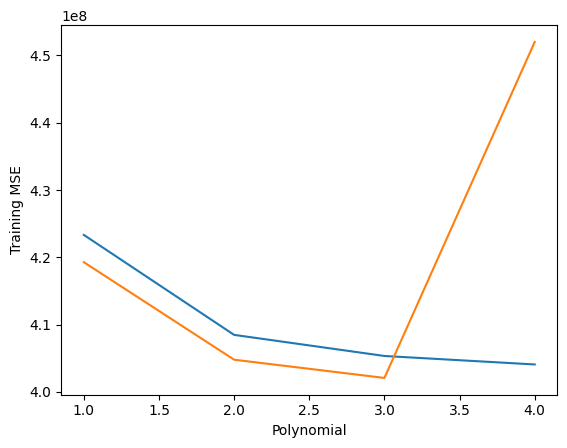

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(vehicle_dataframe_continuous, vehicle_dataframe['price'], random_state=42)

def get_training_and_dev_mse_continuous(polynomial, training_x, training_y, dev_x, dev_y):
    temp_train = training_x.copy()
    temp_dev = dev_x.copy()
    poly = PolynomialFeatures(degree=polynomial)

    new_features = pd.DataFrame(poly.fit_transform(temp_train[["year", "odometer"]]), columns=poly.get_feature_names_out())
    new_features.index = temp_train.index
    del new_features["1"]
    del temp_train["year"]
    del temp_train["odometer"]
    temp_train = pd.concat([temp_train, new_features], axis=1)

    new_features = pd.DataFrame(poly.fit_transform(temp_dev[["year", "odometer"]]), columns=poly.get_feature_names_out())
    new_features.index = temp_dev.index
    del new_features["1"]
    del temp_dev["year"]
    del temp_dev["odometer"]
    temp_dev = pd.concat([temp_dev, new_features], axis=1)

    vehicle_pipe_price_model = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression(fit_intercept=False))])
    vehicle_pipe_price_model.fit(temp_train, training_y)
    training_error = mean_squared_error(training_y, vehicle_pipe_price_model.predict(temp_train))
    dev_error = mean_squared_error(dev_y, vehicle_pipe_price_model.predict(temp_dev))
    return [(polynomial, training_error, dev_error), vehicle_pipe_price_model]

results = [get_training_and_dev_mse_continuous(polynom, X_train, y_train, X_test, y_test)[0] for polynom in range(1, 5)]
results = pd.DataFrame(results, columns=["Polynomial", "Training MSE", "Dev MSE"])

print(results)

sns.lineplot(results, x="Polynomial", y="Training MSE")
sns.lineplot(results, x="Polynomial", y="Dev MSE")

In [17]:
vehicle_continuos_price_model = get_training_and_dev_mse_continuous(3, X_train, y_train, X_test, y_test)[1]
feature_names = pd.Series(vehicle_continuos_price_model.feature_names_in_)

odometer_year_index = feature_names.loc[feature_names.str.contains("odometer") | feature_names.str.contains("year")]
continuous_coef = pd.DataFrame()
continuous_coef["Continuous Feature"] = odometer_year_index
continuous_coef["Coefficient"] = pd.Series(vehicle_continuos_price_model['linreg'].coef_).iloc[odometer_year_index.index]
continuous_coef.sort_values("Coefficient", ascending=False, inplace=True)
continuous_coef = sns.barplot(data=continuous_coef, x="Coefficient", y="Continuous Feature")
continuous_fig = continuous_coef.get_figure()
plt.tight_layout()
continuous_fig.savefig("images/linear_regression/year-odometer_coef.png")
plt.clf()
 

<Figure size 640x480 with 0 Axes>

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(vehicle_dataframe_categorical, vehicle_dataframe['price'], random_state=42)

vehicle_categorical_price_model = Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression(fit_intercept=False))])
vehicle_categorical_price_model.fit(X_train, y_train)

feature_names = pd.Series(vehicle_categorical_price_model.feature_names_in_)

plt.clf()
for key, values in category_new_columns.items(): # to simplify review of coefficients, loop through categories and put subcategories on a plot together
    index_of_sub_categories = feature_names.loc[feature_names.isin(category_new_columns[key])]
    category_specific_coef = pd.DataFrame()
    category_specific_coef["Subcategory"] = index_of_sub_categories
    category_specific_coef["Coefficient"] = pd.Series(vehicle_categorical_price_model['linreg'].coef_).iloc[index_of_sub_categories.index]
    category_specific_coef.sort_values("Coefficient", ascending=False, inplace=True)
    category_coef_plot = sns.barplot(data=category_specific_coef, x="Coefficient", y="Subcategory", hue="Subcategory")
    #category_coef_plot.set_yticklabels(category_coef_plot.get_yticklabels(), rotation=45, ha="right")
    category_fig = category_coef_plot.get_figure()
    plt.tight_layout()
    category_fig.savefig("images/linear_regression/" + key + "_coef.png")
    plt.clf()

<Figure size 640x480 with 0 Axes>

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [19]:
#Please refer to Finding.docx at the root of this project

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

In [20]:
#Please refer to Finding.docx at the root of this project